# Train classifier word/move then left/right
Preprocess the data , then train 2 classifiers and adjust their hyperparamters (word/move then left/right).

Use 1st and 2nd session to train and the 3rd for evaluation.


In [13]:
import numpy as np
import pandas as pd


from sklearn.utils import shuffle


import pdb

from readers_preprocess import read_filter
from time_to_freq_domain import eval_psd_not_modulated

from dim_reduction import  rank_features, pca_data, select_best_chanels
from transformers import flatten_data, transform_to_one_chanel_data

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
%matplotlib notebook


In [14]:
def reduce_dimensionality(X_train, X_test,y_train):
    """
    does feature selection+pca dim. reduction
    """
    best_features = rank_features(X_train, y_train)
    X_train = X_train[:, best_features]
    X_test = X_test[:, best_features]  
    
    pca = PCA(n_components=0.985)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return X_train, X_test

In [15]:
class two_stage_algoritham_linier():
    """
    fit and adjust hyperparameters for 
    classifiers word/movement -> left/right
    """

    def _fit_stage1(self, X, y):
        parameter_candidates = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 100],'class_weight':['balanced']}]
        self.clf_stage1 = GridSearchCV(estimator=LinearSVC(), cv=5 ,param_grid=parameter_candidates)
        self.clf_stage1.fit(X,y)
        print('stg1')
        print(self.clf_stage1.best_estimator_)


    def _fit_stage2(self, X, y):
            
        parameter_candidates = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 100]}]
        self.clf_stage2 = GridSearchCV(estimator=LinearSVC(), cv=5 ,param_grid=parameter_candidates)
        self.clf_stage2.fit(X,y)
        print('stg2')
        print(self.clf_stage2.best_estimator_)


    def fit(self, X1, X2, y1, y2):
        
        X1, y1 = shuffle(X1, y1)
        X2, y2 = shuffle(X2, y2)
        
        self._fit_stage1(X1, y1)
        self._fit_stage2(X2, y2)
        
    def predict(self, X1, X2):
        y1 = self.clf_stage1.predict(X1)
        y2 = self.clf_stage2.predict(X2)
        combined_preds = []
        for idx in range(len(y1)):
            if y1[idx]:
                combined_preds.append(2)
            else: 
                combined_preds.append(y2[idx])
                
        self.y1 = y1
        self.y2 = y2
        
        return combined_preds
    
    
class two_stage_algoritham_rbf():

    def _fit_stage1(self, X, y):

        parameter_candidates = [
              {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.12, 0.1,0.08, 0.01], 'kernel': ['rbf'], 'class_weight':['balanced']},
        ]
        self.clf_stage1 = GridSearchCV(estimator=SVC(), cv=5 ,param_grid=parameter_candidates)
        self.clf_stage1.fit(X,y)
        print('stg1')

        print(self.clf_stage1.best_estimator_)
        
    def _fit_stage2(self, X, y):


        parameter_candidates = [
              {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma':  [0.12, 0.1,0.08, 0.01], 'kernel': ['rbf']},
        ]
        self.clf_stage2 = GridSearchCV(estimator=SVC(), cv=5 ,param_grid=parameter_candidates)
        self.clf_stage2.fit(X,y)
        print('stg2')
        print(self.clf_stage2.best_estimator_)


    def fit(self, X1, X2, y1, y2):
        
        X1, y1 = shuffle(X1, y1)
        X2, y2 = shuffle(X2, y2)
        
        self._fit_stage1(X1, y1)
        self._fit_stage2(X2, y2)
        
    def predict(self, X1, X2):
        y1 = self.clf_stage1.predict(X1)
        y2 = self.clf_stage2.predict(X2)
        combined_preds = []
        for idx in range(len(y1)):
            if y1[idx]:
                combined_preds.append(2)
            else: 
                combined_preds.append(y2[idx])#when the class is movement, take prediction from left/right predictor
                
        self.y1 = y1
        self.y2 = y2
        
        return combined_preds
    
    


    
def reduce_dimensionality(X_train, X_test,y_train):
    best_features = rank_features(X_train, y_train)
    X_train = X_train[:, best_features]
    X_test = X_test[:, best_features]  
    
    pca = PCA(n_components=0.985)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return X_train, X_test




all_paths = [['data_bci\\row_data\\subject1\\'], ['data_bci\\row_data\\subject2\\'],['data_bci\\row_data\\subject3\\']]
keep_columns = ['F4', 'F3', 'AF4', 'AF3', 'class']
columns_to_read =  ['Fp1', 'AF3' ,'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                   'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                   'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz','class']

test_subject = '03'#number test sesion
freq = 512
train_subjects = ['01', '02']#nummber of train sessions




num_perseg = 128 #segment lenght
num_overlap = 64 #ovarlap between segments
freq=512 #sampling frequency
min_freq = 8 #low freq. cutoff
max_freq = 45 #high freq. cutoff


chanels_rank =  [25,  4,  9, 26, 30, 11,  7]#chanels index selected from the selection procedure
report = {
    'SVM_linier accuracy':[],
    'SVM_linier confusion_matrix':[],
    'SVM_rbf accuracy':[],
    'SVM_rbf confusion_matrix':[] 
}

for path in all_paths:
    cutoff_beggining = 0
    seq_len = 0
    cut_step = 0
    #load data
    #Long segments are evaluated for the train data(about 15 sec.) and short for the test data(1 sec)
    train_data, _, train_anots, test_data, _, test_annoations = read_filter(path, train_subjects, test_subject, columns_to_read, cutoff_beggining, seq_len, cut_step)
    seq_len = freq
    cut_step = int(seq_len/2)
    window_train_data, _, window_train_anots, window_test_data, _, window_test_annoations = read_filter(path, train_subjects, test_subject, columns_to_read, cutoff_beggining, seq_len, cut_step)
   

    y_train = train_anots
    y_train_move_word = (y_train == 2)
    y_train_left_right = y_train[y_train!=2]
    
    
    y_test = window_test_annoations

    
    #extract features 
    X_train =  eval_psd_not_modulated(train_data, num_perseg, num_overlap, freq, min_freq, max_freq)
    X_test =  eval_psd_not_modulated(window_test_data, num_perseg, num_overlap, freq, min_freq, max_freq)
        
    X_train = flatten_data(X_train[:,:,chanels_rank])
    X_test = flatten_data(X_test[:,:,chanels_rank]) 
    

    #apply feature selection and PCA
    X_train_move_word, X_test_move_word = reduce_dimensionality(X_train, X_test, y_train_move_word)
    
    X_train_left_right = X_train[y_train != 2]
    
    X_train_left_right, X_test_left_right = reduce_dimensionality(X_train_left_right, X_test, y_train_left_right)

    #normalize
    max_el = X_train_move_word.max() 
    min_el = X_train_move_word.min()

    X_train_move_word = (X_train_move_word-min_el)/(max_el-min_el)
    X_test_move_word = (X_test_move_word-min_el)/(max_el-min_el)
    
    
    
    max_el = X_train_left_right.max() 
    min_el = X_train_left_right.min()
    
    X_train_left_right = (X_train_left_right-min_el)/(max_el-min_el)
    X_test_left_right = (X_test_left_right-min_el)/(max_el-min_el)
    
    # fit classifiers 
    linier = two_stage_algoritham_linier()
    rbf = two_stage_algoritham_rbf()
    print('a')
    linier.fit(X_train_move_word, X_train_left_right, y_train_move_word, y_train_left_right)
    print('b')
    rbf.fit(X_train_move_word, X_train_left_right, y_train_move_word, y_train_left_right)
    

    #evaluate classifiers
    print('s')
    y_pred_linier = linier.predict(X_test_move_word, X_test_left_right)
    print('e')
    y_pred_rbf = rbf.predict(X_test_move_word, X_test_left_right)
    
    acc_linier = accuracy_score(y_test, y_pred_linier)
    conf_linier = confusion_matrix(y_test, y_pred_linier)
    
    acc_rbf = accuracy_score(y_test, y_pred_rbf)
    conf_rbf = confusion_matrix(y_test, y_pred_rbf)
    

    
    

    report['SVM_linier accuracy'].append(acc_linier)
    report['SVM_linier confusion_matrix'].append(conf_linier)
    report['SVM_rbf accuracy'].append(acc_rbf)
    report['SVM_rbf confusion_matrix'].append(conf_rbf)  

a
stg1
LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
stg2
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
b
stg1
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.12, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
stg2
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.12, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
s
e
a
stg1
LinearSVC(C=100, class_weight='balanced', dual=True, fit_intercept=True,
    

In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook




def plot_confusion_matrix(data, key, classes,
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    
    cm = np.array(data[key]).sum(axis=0)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=key,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



<IPython.core.display.Javascript object>


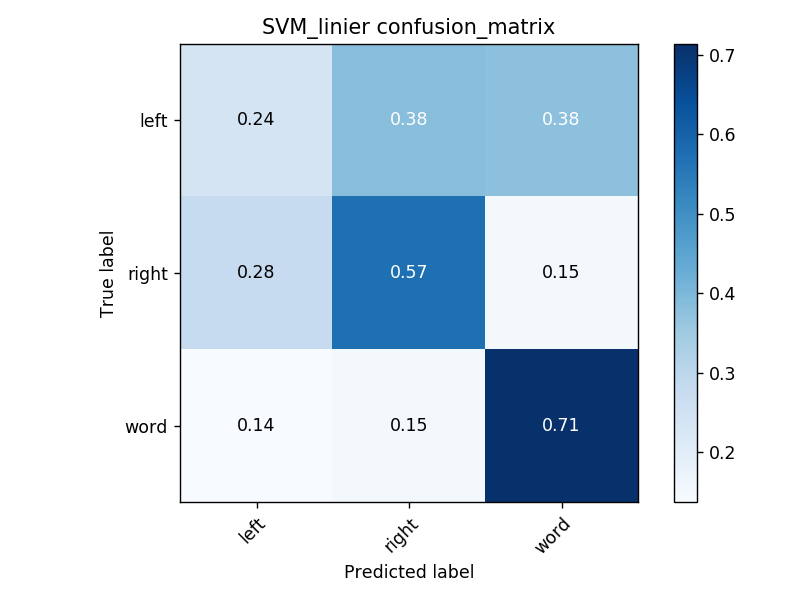

In [17]:
classes = ['left','right','word']
plot_confusion_matrix(report,'SVM_linier confusion_matrix', classes)

<IPython.core.display.Javascript object>


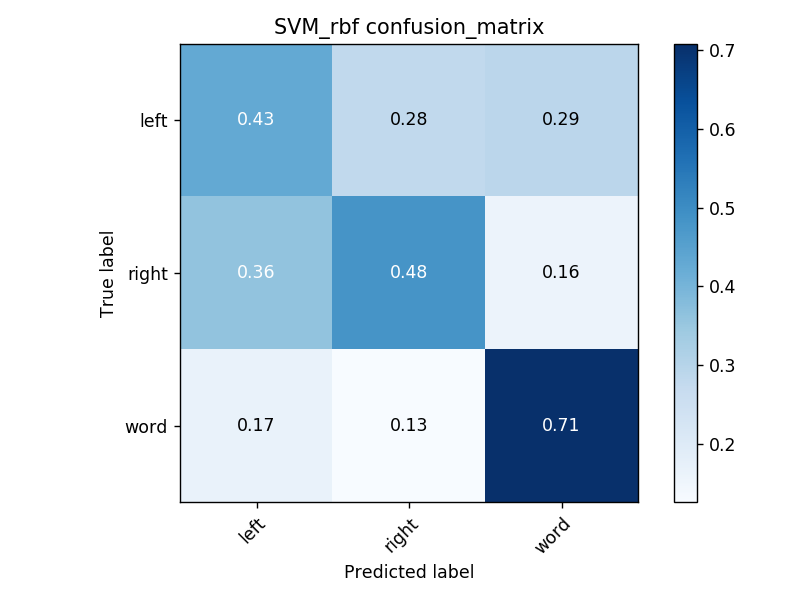

In [18]:
plot_confusion_matrix(report,'SVM_rbf confusion_matrix', classes)

In [19]:

df = pd.DataFrame.from_dict(report)
df = df[['SVM_linier accuracy', 'SVM_rbf accuracy']]
df.columns = ['linear','rbf']
df = df.T
df.index.name = 'SVM'

df.columns = ['person 1', 'person 2', 'person 3']
mean = df.mean(axis=1)
std = df.std(axis=1) 
df['mean accuracy'] = mean
df['std_accuracy'] = std
df = df.round(3)
df.to_excel("2_stage_SVMs.xlsx")
df

,person 1,person 2,person 3,mean accuracy,std_accuracy
SVM,,,,,
linear,0.604,0.502,0.471,0.526,0.07
rbf,0.678,0.504,0.473,0.552,0.11
